# Analysis on COVID-19 Vaccination and Mortality Rates in the United States

Author: Hannah Maung

### Datasets
In this analysis, I will be comparing COVID-19 vaccination rates and mortality rates, and evaluating their correlation. The datasets I will be using in this notebook can be found at the following: 
- **Our World In Data**: https://ourworldindata.org/us-states-vaccinations
    - State-by-state data on COVID-19 vaccinations in the United States
- **CDC**: https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
    - State-by-state data on COVID-19 excess deaths associated with COVID-19 in the United States

In [315]:
#all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import pyspark.pandas as ps
import config as cf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.sql.functions import col
import os
from sqlalchemy import func
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [316]:
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

In [317]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# 1. Exploratory data analysis

In [318]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

#creating a spark dataframe(1)
df_matches1 = load_dataframe('us_state_vaccinations.csv')

#creating a spark dataframe(2)
df_matches2 = load_dataframe('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [319]:
#creating a pandas dataframe(1)
plot1 = pd.read_csv("us_state_vaccinations.csv")

#dropping locations outside of the US for pandas df
plot1_new = plot1[(plot1.location != 'Republic of Palau') & (plot1.location != 'Federated States of Micronesia') & (plot1.location != 'Marshall Islands') & (plot1.location != 'Virgin Islands') & (plot1.location != 'American Samoa') & (plot1.location != 'Northern Mariana Islands') & (plot1.location != 'Guam') & (plot1.location != 'Bureau of Prisons') & (plot1.location != 'Dept of Defense') & (plot1.location != 'Puerto Rico')& (plot1.location != 'District of Columbia')& (plot1.location != 'Indian Health Svc') & (plot1.location != "United States")]

#creatind a pandas dataframe(2)
plot2 = pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")

In [320]:
#using withColumn(), a transformation function
#updates value from string to integer
df_matches1 = df_matches1.withColumn('total_vaccinations',col('total_vaccinations').cast('integer'))
df_matches1 = df_matches1.withColumn('people_vaccinated',col('people_vaccinated').cast('integer'))
df_matches1 = df_matches1.withColumn('people_fully_vaccinated_per_hundred',col('people_fully_vaccinated_per_hundred').cast('integer'))
df_matches1 = df_matches1.withColumn('total_vaccinations_per_hundred',col('total_vaccinations_per_hundred').cast('integer'))
df_matches2 = df_matches2.withColumn('tot_death',col('tot_death').cast('integer'))

In [321]:
#Getting rid of null values
df1 = df_matches1.dropna()
df2 = df_matches2.dropna()

In [322]:
#Changing date format of dataset2 
df2.select(current_date().alias("submission_date"), \
      date_format(current_date(),"yyyy MM dd").alias("yyyy MM dd"), \
      date_format(current_timestamp(),"MM/dd/yyyy hh:mm").alias("MM/dd/yyyy"), \
      date_format(current_timestamp(),"yyyy MMM dd").alias("yyyy MMMM dd"), \
      date_format(current_timestamp(),"yyyy MMMM dd E").alias("yyyy MMMM dd E") \
   ).show(3)

+---------------+----------+----------------+------------+---------------+
|submission_date|yyyy MM dd|      MM/dd/yyyy|yyyy MMMM dd| yyyy MMMM dd E|
+---------------+----------+----------------+------------+---------------+
|     2022-05-25|2022 05 25|05/25/2022 08:46| 2022 May 25|2022 May 25 Wed|
|     2022-05-25|2022 05 25|05/25/2022 08:46| 2022 May 25|2022 May 25 Wed|
|     2022-05-25|2022 05 25|05/25/2022 08:46| 2022 May 25|2022 May 25 Wed|
+---------------+----------+----------------+------------+---------------+
only showing top 3 rows



In [323]:
#Displays the first 10 rows of dataframe 1 
df1.limit(10).toPandas()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,total_boosters,total_boosters_per_hundred
0,2021-10-21,Alabama,4732829,6999770.0,2637734,44,96,2165154.0,53.8,142.76,9910.0,9029.0,1841.0,0.676,134615,2.75
1,2021-10-22,Alabama,4742444,7045270.0,2644229,44,96,2170323.0,53.93,143.69,9615.0,9226.0,1882.0,0.673,138996,2.83
2,2021-10-23,Alabama,4759947,7062480.0,2648588,44,97,2174923.0,54.02,144.04,17503.0,10252.0,2091.0,0.674,147525,3.01
3,2021-10-24,Alabama,4766186,7061780.0,2650133,44,97,2176540.0,54.05,144.02,6239.0,8961.0,1828.0,0.675,150656,3.07
4,2021-10-25,Alabama,4773728,7058840.0,2652037,44,97,2177980.0,54.09,143.96,7542.0,9136.0,1863.0,0.676,154781,3.16
5,2021-10-26,Alabama,4779470,7069650.0,2653566,44,97,2179242.0,54.12,144.18,5742.0,9345.0,1906.0,0.676,157914,3.22
6,2021-10-27,Alabama,4805213,7123260.0,2659115,44,98,2183682.0,54.23,145.28,25743.0,11756.0,2398.0,0.675,173615,3.54
7,2021-10-28,Alabama,4827200,7163060.0,2663952,44,98,2187378.0,54.33,146.09,21987.0,13482.0,2750.0,0.674,186912,3.81
8,2021-10-29,Alabama,4847422,7220460.0,2668028,44,98,2190701.0,54.41,147.26,20222.0,14997.0,3059.0,0.671,199742,4.07
9,2021-10-30,Alabama,4866607,7264740.0,2672040,44,99,2194074.0,54.5,148.16,19185.0,15237.0,3108.0,0.67,211878,4.32


In [324]:
#Displays the first 10 rows of dataframe 2
df2.limit(10).toPandas()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/18/2020,ME,44,44,0,12,0,0,0,0,0,0,03/20/2020 12:00:00 AM,Agree,Agree
1,10/06/2021,DE,134690,124148,10542,444,45,1977,1810,167,2,0,10/08/2021 12:00:00 AM,Agree,Agree
2,06/15/2020,WI,25480,22932,2548,185,11,700,694,6,2,0,06/16/2020 02:10:11 PM,Agree,Agree
3,12/25/2021,MS,525502,299857,225645,0,0,10393,6958,3435,0,0,12/27/2021 02:16:24 PM,Agree,Agree
4,07/06/2020,AL,44854,44350,504,903,12,1473,1358,115,17,2,07/08/2020 12:00:00 AM,Agree,Agree
5,06/12/2021,ME,68578,50293,18285,39,16,845,817,28,0,0,06/14/2021 12:00:00 AM,Agree,Agree
6,01/01/2022,WI,1120669,994535,126134,0,0,11173,10063,1110,0,0,01/03/2022 01:55:55 PM,Agree,Agree
7,02/14/2021,CT,267337,250915,16422,0,0,7381,6049,1332,0,0,02/15/2021 02:46:24 PM,Agree,Agree
8,07/16/2021,DE,109472,102240,7232,40,14,1697,1551,146,1,0,07/18/2021 12:00:00 AM,Agree,Agree
9,01/30/2022,MI,2235180,1959371,275809,0,0,32197,29778,2419,0,0,01/31/2022 04:55:36 PM,Agree,Agree


In [325]:
#getting rid of unused columns for dataset1
df_matches1_drop = df1.drop('total_boosters_per_hundred',
                                    'total_boosters',
                                   'share_doses_used',
                                    'daily_vaccinations_raw',
                                   )

In [326]:
#getting rid of unused colums for dataset2
df_matches2_drop = df_matches2.drop('consent_deaths',
                                  'consent_cases',
                                  'created_at',
                                  'pnew_death',
                                  'prob_death',
                                  'conf_death',
                                  'pnew_case',
                                 'conf_death',
                                 'prob_cases')

In [327]:
#dropping locations that are outside of the United States
df1_new = df_matches1.where(df_matches1.location != 'Republic of Palau')
df2_new = df1_new.where(df1_new.location != 'Federated States of Micronesia')
df3_new = df2_new.where(df2_new.location != 'Marshall Islands')
df4_new = df3_new.where(df3_new.location != 'Virgin Islands')
df5_new = df4_new.where(df4_new.location != 'American Samoa')
df6_new = df5_new.where(df5_new.location != 'Guam')
df7_new = df6_new.where(df6_new.location != 'Bureau of Prisons')
df8_new = df7_new.where(df7_new.location != 'Dept of Defense')
df9_new = df8_new.where(df8_new.location != 'Puerto Rico')
df10_new = df9_new.where(df9_new.location != 'District of Columbia')
df11_new = df10_new.where(df10_new.location != 'Indian Health Svc')
df11_new = df10_new.where(df10_new.location != 'Indian Health Svc')

In [328]:
#calculating some statistical data for spark df1 for total vaccinations
df11_new.select('total_vaccinations').describe().show()

+-------+--------------------+
|summary|  total_vaccinations|
+-------+--------------------+
|  count|               21889|
|   mean|1.2364101469505232E7|
| stddev| 4.963006352150097E7|
|    min|                3722|
|    max|           563999093|
+-------+--------------------+



In [329]:
#calculating some statistical data for spark df2 for total death
df2.select('tot_death').describe().show()

+-------+------------------+
|summary|         tot_death|
+-------+------------------+
|  count|             21951|
|   mean| 8853.572411279669|
| stddev|11131.980887238053|
|    min|                 0|
|    max|             71408|
+-------+------------------+



In [330]:
#Displaying all locations in the spark df1 
df11_new.select('location').toPandas()

,location
0,Alabama
1,Alabama
2,Alabama
3,Alabama
4,Alabama
...,...
24190,Wyoming
24191,Wyoming
24192,Wyoming
24193,Wyoming


# 2. Analyzing COVID-19 Vaccination Rates in the U.S.


We can see that there have been 563,999,093 total COVID-19 vaccination doses given and 255.975,678 total people fully vaccinated in the United States.

In [331]:
#Aggregates over column total_vaccination of spark df1
max_value = df11_new.agg({'total_vaccinations': 'max'}).show()
#Finds max for total_vaccination column of pandas df1
plot1[plot1["total_vaccinations"] == plot1["total_vaccinations"].max()][["date", "location","total_vaccinations"]]

+-----------------------+
|max(total_vaccinations)|
+-----------------------+
|              563999093|
+-----------------------+



,date,location,total_vaccinations
25096,2022-04-07,United States,563999093.0


In [332]:
#Aggregates over column people_vaccinated of spark df1
df11_new.agg({'people_vaccinated':'max'}).show()
#Finds max for people vaccinated column of pandas df1
plot1[plot1["people_vaccinated"] == plot1["people_vaccinated"].max()][["date", "location","people_vaccinated"]]

+----------------------+
|max(people_vaccinated)|
+----------------------+
|             255975678|
+----------------------+



,date,location,people_vaccinated
25096,2022-04-07,United States,255975678.0


In our dataset, the state with the highest number of COVID-19 vaccine doses administered is California.

In [333]:
#Aggregates over column people_vaccinated of spark df1 not in US
data = df_matches1.where(df_matches1.location != 'United States')
data.agg({'people_vaccinated': 'max'}).show()

#Finds max for people vaccinated column of pandas df1
df3 = plot1_new[(plot1_new.location != "United States") & (plot1_new.date == "2022-04-07")]
df3[df3["total_vaccinations"] == df3["total_vaccinations"].max()][["date", "location","total_vaccinations"]]

+----------------------+
|max(people_vaccinated)|
+----------------------+
|              32670894|
+----------------------+



,date,location,total_vaccinations
3156,2022-04-07,California,73084268.0


#### US: COVID-19 Vaccine Doses Administered, April 07, 2022. (Top 10 States)

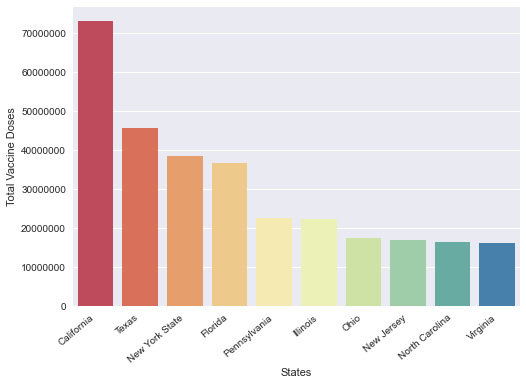

In [334]:
df3 = plot1_new[(plot1_new.location != "United States") & (plot1_new.date == "2022-04-07")]

high_vaccine_df = df3.sort_values('total_vaccinations',ascending=False)[:10]
high_vaccine = high_vaccine_df[['location', 'total_vaccinations']]

#plots bar graph
expensiveplot = sns.barplot(x = 'location',y='total_vaccinations', data=high_vaccine, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='Total Vaccine Doses')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### US: COVID-19 Vaccine Doses Administered, April 07, 2022. (Bottom 10 States)

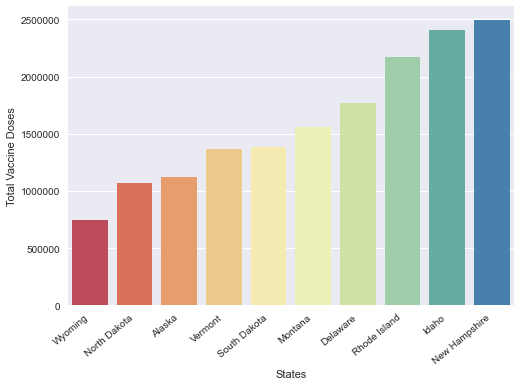

In [335]:
#sorts people vaccinated values from descending order
high_vaccine_df = df3.sort_values('total_vaccinations',ascending=True)[:10]
high_vaccine2 = high_vaccine_df[['location', 'total_vaccinations']]

#plots bar graph
expensiveplot = sns.barplot(x = 'location',y='total_vaccinations', data=high_vaccine2, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='Total Vaccine Doses')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

### However, to get a more accurate estimation and analysis, we need to compare rates per hundred people so that it takes into account the state's population. 

Rhode Island has the highest percentage of its population fully vaccinated.

In [336]:
#finding max of spark dataframe of people fully vaccinated per hundred
df11_new.agg({'people_fully_vaccinated_per_hundred':'max'}).show()

#finding max of pandas dataframe of people fully vaccinated per hundred
plot1_new[plot1_new["people_fully_vaccinated_per_hundred"] == plot1_new["people_fully_vaccinated_per_hundred"].max()][["date", "location","people_fully_vaccinated_per_hundred"]]

+----------------------------------------+
|max(people_fully_vaccinated_per_hundred)|
+----------------------------------------+
|                                      83|
+----------------------------------------+



,date,location,people_fully_vaccinated_per_hundred
22818,2022-04-07,Rhode Island,81.83


Alabama has the lowest percentage of its population fully vaccinated. 

In [337]:
#finding min of pandas dataframe of people fully vaccinated per hundred
df3 = plot1_new[(plot1_new.date == "2022-04-07")]
df3[df3["people_fully_vaccinated_per_hundred"] == df3["people_fully_vaccinated_per_hundred"].min()][["date", "location","people_fully_vaccinated_per_hundred"]]

,date,location,people_fully_vaccinated_per_hundred
450,2022-04-07,Alabama,50.76


#### US: COVID-19 Fully Vaccinated People Per Hundred, April 07, 2022. (Top 10 States)

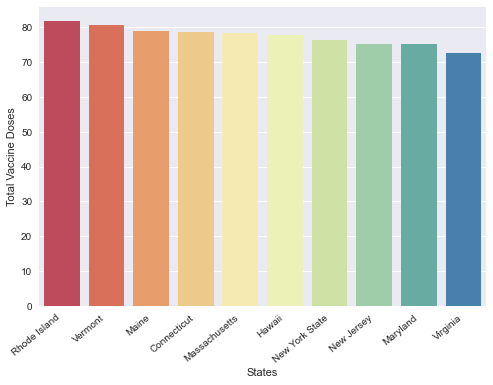

In [338]:
df3 = plot1_new[(plot1_new.location != "United States") & (plot1_new.date == "2022-04-07")]

#sorts people vaccinated values from descending order
high_vaccine_df = df3.sort_values('people_fully_vaccinated_per_hundred',ascending=False)[:10]
high_vaccine = high_vaccine_df[['location', 'people_fully_vaccinated_per_hundred']]

#plots bar graph
expensiveplot = sns.barplot(x = 'location',y='people_fully_vaccinated_per_hundred', data=high_vaccine, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='Total Vaccine Doses')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### US: COVID-19 Fully Vaccinated People Per Hundred, April 07, 2022. (Bottom 10 States)

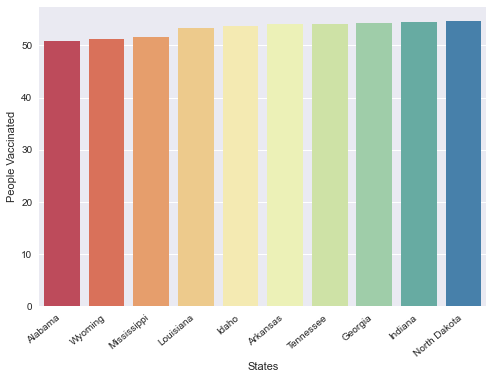

In [339]:
high_vaccine_df = df3.sort_values('people_fully_vaccinated_per_hundred',ascending=True)[:10]
high_vaccine4 = high_vaccine_df[['location', 'people_fully_vaccinated_per_hundred']]

#plots bar graph
expensiveplot = sns.barplot(x = 'location',y='people_fully_vaccinated_per_hundred', data=high_vaccine4, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='People Vaccinated')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

# 3. Analyzing COVID-19 Total Deaths in the U.S.


We can see that the highest death total is in California, with 88,355 deaths.

In [340]:
#Aggregates over column tot_death of spark df2
max_value = df_matches2.agg({'tot_death': 'max'}).show()

#Finds max for tot_death column of pandas df2
plot2[plot2["tot_death"] == plot2["tot_death"].max()][["submission_date", "state","tot_death"]]

+--------------+
|max(tot_death)|
+--------------+
|         88355|
+--------------+



,submission_date,state,tot_death
281,04/06/2022,CA,88355
35372,04/05/2022,CA,88355


We can see that the lowest death total is in Vermont, with 590 total deaths. 

In [341]:
#Filters with conditions, date and locations not in US
new = plot2[(plot2.submission_date == "04/06/2022") & (plot2.state != 'RMI')& (plot2.state != 'FSM')& (plot2.state != 'PW') & (plot2.state != 'AS')& (plot2.state != 'MP')& (plot2.state != 'VI')& (plot2.state != 'GU')]

#Finds min for tot_death column of pandas df2
new[new["tot_death"] == new["tot_death"].min()][["submission_date", "state","tot_death"]]

,submission_date,state,tot_death
5410,04/06/2022,VT,590


#### US: COVID-19 deaths (Highest 10 States)

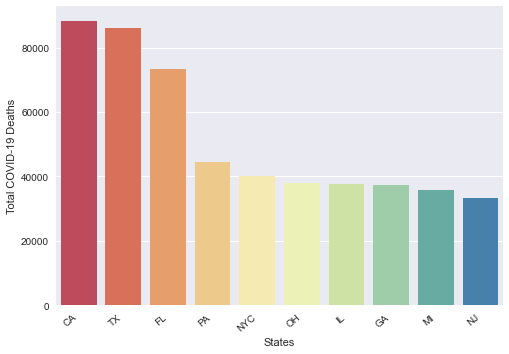

In [342]:
#sorts people vaccinated values from descending order
high_vaccine_df = new.sort_values('tot_death',ascending=False)[:10]
high_vaccine = high_vaccine_df[['state', 'tot_death']]

#plots bar graph
expensiveplot = sns.barplot(x = 'state',y='tot_death', data=high_vaccine, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='Total COVID-19 Deaths')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### US: COVID-19 deaths (Lowest 10 States)

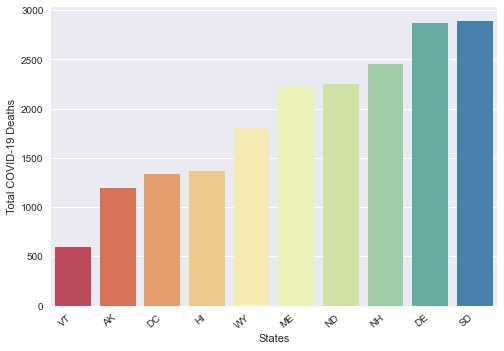

In [343]:
#sorts people vaccinated values from descending order
high_vaccine_df = new.sort_values('tot_death',ascending=True)[:10]
high_vaccine = high_vaccine_df[['state', 'tot_death']]

#plots bar graph
expensiveplot = sns.barplot(x = 'state',y='tot_death', data=high_vaccine, palette="Spectral")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='States', ylabel='Total COVID-19 Deaths')

plt.ticklabel_format(style='plain', axis='y')
plt.show()

# 4. Comparing Results


From Part 2, we know that the state with the highest vaccination rate is Rhode Island, with 83.81%. Let's see what their COVID-19 total death amount is: 

In [344]:
#filtering rows, finding the row for Rhode Island
df_matches2_drop.filter((df_matches2_drop.state  == "RI") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   RI|   343580|      null|     242|     3522|        0|
+---------------+-----+---------+----------+--------+---------+---------+



We can see that Rhode Island's total death count is pretty low, with 3522 total cases. 

From Part 2, we also know that the state with the lowest vaccination rate is Alabama. Let's see what their COVID-19 total death amount is:

In [345]:
#filtering rows, finding the row for Alabama
df_matches2_drop.filter((df_matches2_drop.state  == "AL") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   AL|  1295737|    932570|     276|    19374|        0|
+---------------+-----+---------+----------+--------+---------+---------+



The state with the second highest vaccination rate is Vermont. The following is a table that contains their death total:

In [346]:
#filtering rows, finding the row for Vermont
df_matches2_drop.filter((df_matches2_drop.state  == "VT") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   VT|   108249|      null|       0|      587|        0|
+---------------+-----+---------+----------+--------+---------+---------+



The state with the third highest vaccination rate is Maine. The following is a table that contains their death total: 

In [347]:
#filtering rows, finding the row for Maine
df_matches2_drop.filter((df_matches2_drop.state  == "ME") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   ME|   236259|    171078|     213|     2202|        0|
+---------------+-----+---------+----------+--------+---------+---------+



Vermont and Maine have very low total deaths, with 587 total deaths for Vermont and 2,202 total deaths for Maine. 

The state with the second lowest vaccination rate is Wyoming. The following is a table that contains their death total:

In [348]:
#filtering rows, finding the row for Wyoming
df_matches2_drop.filter((df_matches2_drop.state  == "WY") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   WY|   156167|    123161|      55|     1791|        0|
+---------------+-----+---------+----------+--------+---------+---------+



In [349]:
#filtering rows, finding the row for Mississippi
df_matches2_drop.filter((df_matches2_drop.state  == "MS") & (df_matches2_drop.submission_date  == "04/01/2022")).show()

+---------------+-----+---------+----------+--------+---------+---------+
|submission_date|state|tot_cases|conf_cases|new_case|tot_death|new_death|
+---------------+-----+---------+----------+--------+---------+---------+
|     04/01/2022|   MS|   794721|    436748|     163|    12399|        2|
+---------------+-----+---------+----------+--------+---------+---------+



##### In order to accurately compare death and vaccination rates, we need to calculate the mortality rate.

In order to do this, we will divide the total number of deaths/total population of that state. It will be expressed in units per 100 individuals. The following includes calculations and the answers, which represents the total percentage of people of that state's population that died from COVID-19:

In [350]:
rhode_island = (3522/1058000)*100
vermont = (587/624340)*100
maine = (2202/1341000)*100

alabama = (19374/4893000)*100
wyoming = (1791/581348)*100
mississippi = (12399/2982000)*100

In [351]:
rhode_island

0.3328922495274102

In [352]:
vermont

0.09401928436428869

In [353]:
maine

0.16420581655480984

In [354]:
alabama

0.3959534028203556

In [355]:
wyoming

0.30807708979819315

In [356]:
mississippi

0.41579476861167003

Text(0, 0.5, 'Mortality Rate')

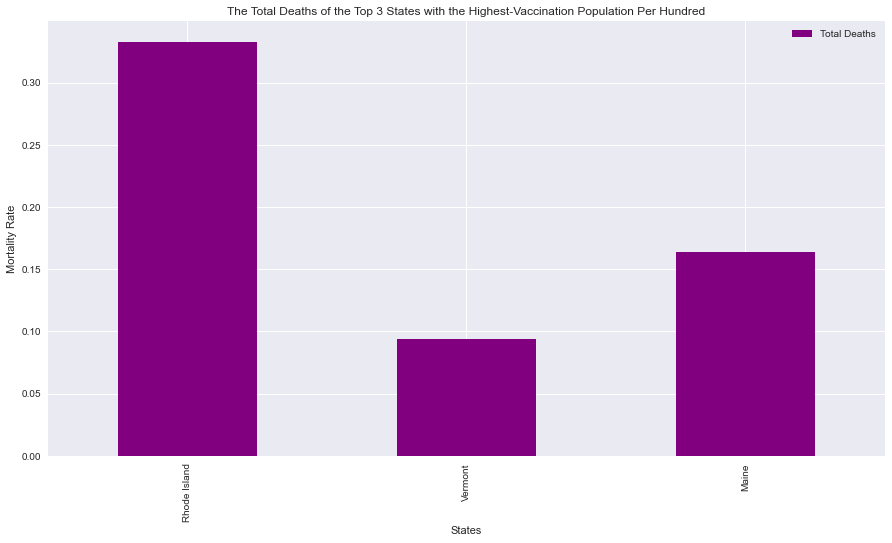

In [363]:
#Creating a bar graph of Top 3 states with the highest vac pertentage
plotdata = pd.DataFrame({"Total Deaths":[rhode_island, vermont, maine]},index = ["Rhode Island", "Vermont", "Maine"])
plotdata.plot(kind="bar",figsize=(15, 8),color="purple")
plt.title("The Total Deaths of the Top 3 States with the Highest-Vaccination Population Per Hundred")
plt.xlabel("States")
plt.ylabel("Mortality Rate")

Text(0, 0.5, 'Mortality Rate')

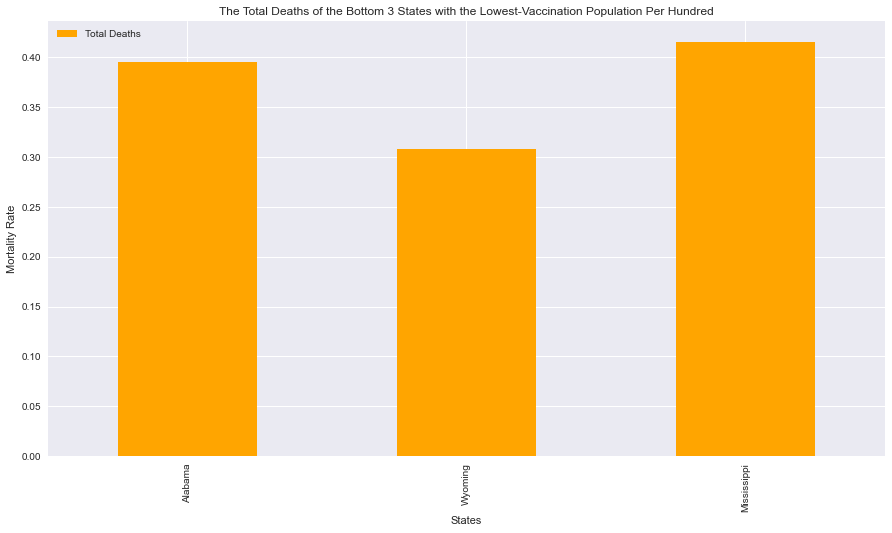

In [362]:
plotdata = pd.DataFrame({"Total Deaths":[alabama,wyoming,mississippi]},index = ["Alabama", "Wyoming", "Mississippi"])
plotdata.plot(kind="bar",figsize=(15, 8),color="orange")
plt.title("The Total Deaths of the Bottom 3 States with the Lowest-Vaccination Population Per Hundred")
plt.xlabel("States")
plt.ylabel("Mortality Rate")

##### From the graphs above, we can see that the three states with the lowest vaccinated population (Alabama, Wyoming, Mississippi) have a slightly higher COVID-19 moratality rate than the three states with the highest vaccinated population (Rhode Island, Vermont, Maine). This means that states that have a higher percentage of people fully-vaccinated correlates to a lower mortality rate. 

##### From these results, we can conclude that there is a slight correlation between COVID-19 vaccination rates and mortality rates, as vaccination rates have a slight impact on mortality rates. 